# Libraries

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import torch

from pathlib import Path

In [2]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
home_path = Path.home()
print(home_path)

current_dir_path = Path.cwd()
print(current_dir_path)

askap = home_path / 'ANU' / 'ASKAP'
data_path = askap / 'data'
ml_data_path = data_path / 'ML'
ppv_data_path = ml_data_path / 'ppv'
seta_data_path = ml_data_path / 'seta22'

train_data_path = ml_data_path / 'train'
exp0_data_path = train_data_path / 'exp0c'

checkpoint_path = exp0_data_path / 'checkpoint'
training_process_path = exp0_data_path / 'training_process'

print(train_data_path)
print(ppv_data_path)

# GPU or CPU

In [8]:
# GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


In [9]:
torch.cuda.device_count()

0

# Fcn

In [16]:
def split_into_chunks(arr, chunk_size):
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

# Read number of CNN layers

Read process (60 epochs)

In [58]:
layer_list = [2, 4, 6, 8, 10, 12, 14]
nlayers    = len(layer_list)
nlayers

7

In [ ]:
pfile_list  = [training_process_path / f'no_pe_{x}_process.csv' for x in layer_list]
pfile_list

In [60]:
nepochs = 60

process_train_rmse_mean = np.zeros((10, nlayers))
process_valid_rmse_mean = np.zeros((10, nlayers))
process_test_rmse_mean  = np.zeros((10, nlayers))

# Loop through your scatter plot data and create subplots
for i, xfile_list in enumerate(pfile_list):
    process_df = pd.read_csv(training_process_path / xfile_list)

    process_train_err    = np.sqrt(process_df['train_err'].values)
    process_validate_err = np.sqrt(process_df['valid_err'].values)
    process_test_err     = np.sqrt(process_df['test_err'].values)
    epochs               = process_df['epoch'].values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
    process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
    process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

    process_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_train_err_chunks])
    process_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_validate_err_chunks])
    process_test_rmse_mean[:,i]  = np.asarray([np.mean(x) for x in process_test_err_chunks])

In [61]:
process_test_rmse_mean.shape

(10, 7)

# Read the CSV

In [ ]:
# To find the optimal number of CNN layers
# N_CNN = 8 layers
layer_list = [2, 4, 6, 8, 10, 12, 14]
nlayers    = len(layer_list)
x          = np.array(layer_list)
file_list  = [training_process_path / f'no_pe_{x}.csv' for x in layer_list]
file_list

In [63]:
valid_mean_mse_arr = np.zeros(nlayers)
valid_std_mse_arr = np.zeros(nlayers)

test_mean_mse_arr = np.zeros(nlayers)
test_std_mse_arr = np.zeros(nlayers)

valid_mean_mse_arr_list = []
test_mean_mse_arr_list  = []

ftest_mean_rmse_arr_list = []
ftest_std_rmse_arr = np.zeros(nlayers)

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  valid_mse_values = np.sqrt(df.valid_err.values) # RMSE
  test_mse_values  = np.sqrt(df.test_err.values)

  valid_mean_mse_arr_list.append(valid_mse_values)
  test_mean_mse_arr_list.append(test_mse_values)

  valid_mean_mse = np.median(valid_mse_values)
  valid_std_mse  = valid_mse_values.std()

  test_mean_mse  = np.median(test_mse_values)
  test_std_mse   = test_mse_values.std()

  valid_mean_mse_arr[i] = valid_mean_mse
  valid_std_mse_arr[i] = valid_std_mse

  test_mean_mse_arr[i] = test_mean_mse
  test_std_mse_arr[i] = test_std_mse

  mean_rmse = (test_mse_values + process_test_rmse_mean[:, i]) / 2.
  ftest_mean_rmse_arr_list.append(mean_rmse)
  ftest_std_rmse_arr[i] = np.median(mean_rmse)

In [68]:
for m,s,xi in zip(valid_mean_mse_arr, valid_std_mse_arr, x):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.134382, std=0.005113  for 2
Valid MSE: Mean=0.095844, std=0.001388  for 4
Valid MSE: Mean=0.083404, std=0.000721  for 6
Valid MSE: Mean=0.077572, std=0.001545  for 8
Valid MSE: Mean=0.075219, std=0.000966  for 10
Valid MSE: Mean=0.068477, std=0.004182  for 12
Valid MSE: Mean=0.092759, std=0.014737  for 14


In [69]:
for m,s,xi in zip(test_mean_mse_arr, test_std_mse_arr, x):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.142664, std=0.004910  for 2
Test MSE: Mean=0.096866, std=0.001325  for 4
Test MSE: Mean=0.081840, std=0.000859  for 6
Test MSE: Mean=0.076463, std=0.000741  for 8
Test MSE: Mean=0.073559, std=0.001152  for 10
Test MSE: Mean=0.075157, std=0.004215  for 12
Test MSE: Mean=0.091307, std=0.014011  for 14


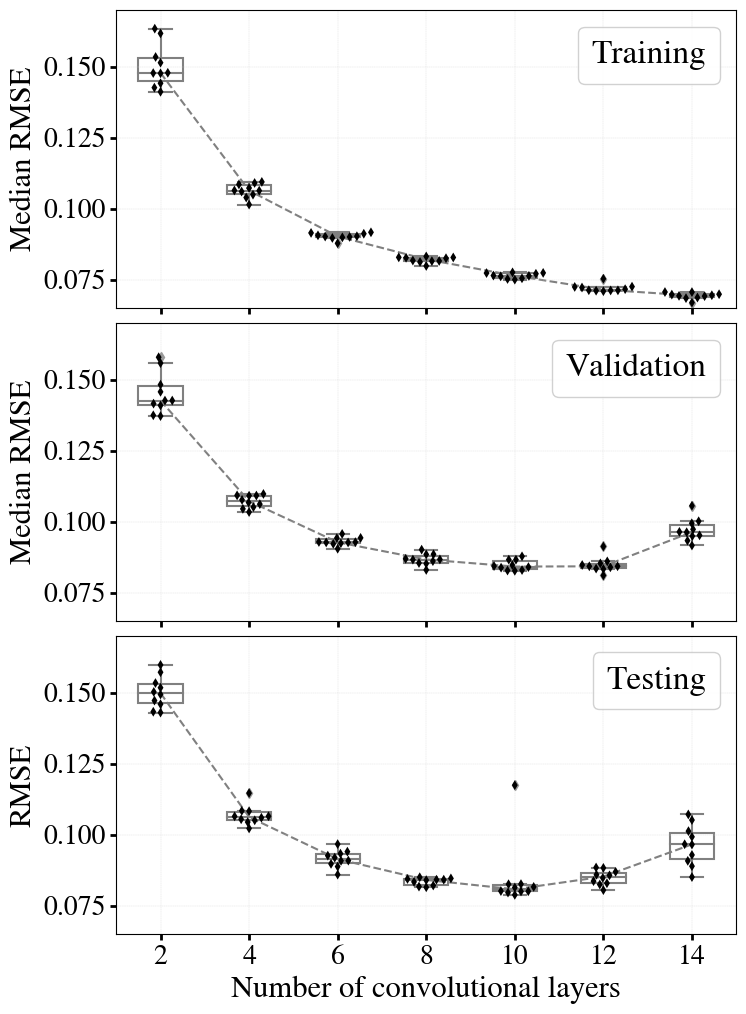

In [72]:
# Set font to Times New Roman
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"


fig, (ax2, ax1, ax) = plt.subplots(figsize=(8,12), nrows=3, sharex=True)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'grey'},
    'medianprops':{'color':'grey'},
    'whiskerprops':{'color':'grey'},
    'capprops':{'color':'grey'}
}



## ax
x = [0, 1, 2, 3, 4, 5, 6]


ploti, = ax2.plot([], [], 'kd', label=r'Training')
ploti.set_visible(True)

sns.swarmplot(data=process_train_rmse_mean, color='k', marker='d', ax=ax2)
sns.boxplot(data=process_train_rmse_mean, width=0.5, color='white', ax=ax2, **PROPS)

ax2.plot(x, np.median(process_train_rmse_mean, axis=0), ls='--', color='gray', zorder=-1, label='')


ax2.set_ylabel(r'Median RMSE', fontsize=22)
ax2.tick_params(axis='both', which='both', length=6, width=1, labelsize=14)

ax2.tick_params(axis='x', labelsize=20, pad=4)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)
ax2.set_ylim(0.065, 0.17)


ax2.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax2.legend(loc='upper right', fancybox=True, framealpha=0.9, labelcolor='k', fontsize=24, handletextpad=-2.)
for item in leg.legendHandles:
    item.set_visible(False)



## ax
ploti, = ax1.plot([], [], 'kd', label=r'Validation')
ploti.set_visible(True)

sns.swarmplot(data=process_valid_rmse_mean, color='k', marker='d', ax=ax1)
sns.boxplot(data=process_valid_rmse_mean, width=0.5, color='white', ax=ax1, **PROPS)

ax1.plot(x, np.median(process_valid_rmse_mean, axis=0), ls='--', color='gray', zorder=-1, label='')

ax1.set_ylabel(r'Median RMSE', fontsize=22)
ax1.tick_params(axis='both', which='both', length=6, width=1, labelsize=14)


ax1.tick_params(axis='x', labelsize=20, pad=4)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)
ax1.set_ylim(0.065, 0.17)


ax1.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax1.legend(loc='upper right', fancybox=True, framealpha=0.9, labelcolor='k', fontsize=24, handletextpad=-2.)
for item in leg.legendHandles:
    item.set_visible(False)



## ax
ploti, = ax.plot([], [], 'kd', label=r'Testing')
ploti.set_visible(True)

sns.swarmplot(data=ftest_mean_rmse_arr_list, color='k', marker='d', ax=ax)
sns.boxplot(data=ftest_mean_rmse_arr_list, width=0.5, color='white', ax=ax, **PROPS)

ax.plot(x, ftest_std_rmse_arr, ls='--', color='gray', zorder=-1, label='')

ax.set_xlabel('Number of convolutional layers', fontsize=22)
ax.set_ylabel(r'RMSE', fontsize=22)
ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=14)


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)
ax.set_ylim(0.065, 0.17)

ax.set_xticklabels([2, 4, 6, 8, 10, 12, 14], rotation=0)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper right', fancybox=True, framealpha=0.9, labelcolor='k', fontsize=24, handletextpad=-2.)
for item in leg.legendHandles:
    item.set_visible(False)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.05
                    )

plt.show()